<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/2.Model-linearization/Linearizacao_de_modelo_nao_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<left><img src="https://github.com/juliosdutra/Controle_de_Processos_UFES/blob/main/imagens/cabe%C3%A7alho-geral.jpg?raw=true" width="700" height="175">
</left>

# Linearização de modelos não lineares

# Usando a biblioteca *Sympy* (opcional)

É um caminho interessante para problemas mais simples. Supondo uma função não-linear dada por $f=f(x)$, é possível linearizar usando matemática simbólica no Python, como é o caso da biblioteca SymPy. Isso é feito para obter a derivada $f^x=∂f/∂x$ necessária para aproximar o modelo em $(x_s)$, tal que

$$f(x)≈f(x_s)+f^x (x_s) (x-x_s )$$

Neste caso, basta importar a biblioteca SymPy, instanciar as variáveis com o método symbols, definir a expressão da função e proceder a derivação como método diff, indicando a função a ser derivada e a respectiva variável. Por exemplo, considere a obtenção das derivadas parciais para a função $f(x)=x^2+cos⁡(x)$. A partir do resultado simbólico, pode-se chegar à função linearizada, tal que $f(x)≈f(x_s)+ [2x_s-sin⁡(x_s)](x-x_s )$.

In [1]:
# Importando o sympy
import sympy as sp
from sympy.plotting import plot

# Instanciando as variáveis
x = sp.symbols('x')

# Definindo a função das variáveis
f = x**2 + sp.cos(x)

# Calculando a derivada parcial, f_x
fx = sp.diff(f,x)

# Especificando o ponto de linearização
x_s = 3.0
ponto = {x:x_s}

# Obtendo a expressão linerizada
f_linear = f.subs(ponto) + fx.subs(ponto)*(x-x_s)
print(f'f_linear = {f_linear}')

f_linear = 5.85887999194013*x - 9.56663247242084


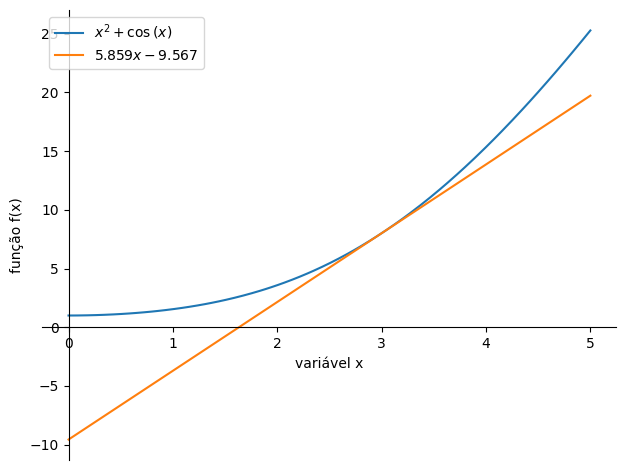

In [2]:
# Simplificando os coeficientes para 4 casas decimais e observando o comportamento gráfico
for coeff in sp.preorder_traversal(f_linear):
    if isinstance(coeff, sp.Float):
       f_linear = f_linear.subs(coeff, round(coeff, 3))

h = plot(f, f_linear, (x, 0, 5),
     xlabel='variável x', ylabel='função f(x)', legend=True);

# Usando a biblioteca *Python-Control*


O procedimento a ser seguido agora se baseia na função linearize presente na biblioteca Python Control Systems (python-control). É um pacote com um conjunto de métodos e funções para implementar operações básicas para análise e projeto de sistemas de controle feedback. Ele requer as bibliotecas usuais numpy, scipy e matplotlib. Mais detalhes podem ser vistos na documentação em: https://python-control.readthedocs.io. A seguir, são apresentados os passos do procedimento:

## 1. Instalar o pacote python-control.

In [3]:
! pip install -qq control

## 2. Importar o pacote control e demais bibliotecas.

In [4]:
import numpy as np
from scipy import linalg
import control as ct
from control.iosys import linearize

## 3. Implementar o modelo do processo e de observação.

A função linearize exige que `params={}` seja colocado juntamente com os outros argumentos usuais, sendo todo separados por vírgulas. Com isso, o modelo implementado para linearização tem como argumento `(t, x, u, params={})`.

Devem ser criadas 2 funções com esses argumentos: uma para o modelo do processo, cuja saída são as derivadas do modelo; e outra com o modelo de observação, cuja saída são as variáveis medidas (que podem ser iguais o conjunto de variáveis de estado).


In [5]:
# Definir os modelos: processo e medição


def reator_CSTR(t,x,u, params={}):

    '''modelo do reator CSTR'''

    # parametros do modelo
    V = 100.0
    rho = 1000.0
    cp = 0.239
    DH = -5e4
    k0 = 7.2e10
    E = 72747.5
    R = 8.314
    Ti = 350.0
    UA = 5e4

    # variáveis de estado
    cA, T = x

    # variáveis de entrada
    q, cAi, Tc = u

    # equações constitutivas
    k = k0*np.exp(-E/(R*T))
    Q = UA*(T-Tc)
    rA = k*cA

    # equações do modelo
    dcA = q/V*(cAi-cA) - rA
    dT = (q*rho*cp*(Ti-T)+(-DH)*rA*V - Q)/(V*rho*cp)

    # saida do modelo
    dx = [dcA, dT]

    return dx


def medida(t, x, u, params={}):

    '''Função de medida'''

    # variáveis de estado
    cA, T = x

    # modelo de observação
    y = [cA, T]

    return y


## 4. Instanciar o modelo implementado.

Deve-se criar uma instância da estrutura I/O do modelo. Isso é feito com a função `NonlinearIOSystem( )`, presente no pacote *python-control*, cuja sintaxe é: `NonlinearIOSystem(updfcn, outfcn=None, inputs=None, outputs=None, states=None, name=None)`. Neste exemplo, a função `linearize` atua sobre o modelo instanciado para um reator, cujo modelo principal (`updfcn`) tem o nome “modelo_reator” e o de observação (`outfcn`) “medida_reator”. Definem-se as variáveis simbólicas para os estados, entradas e saídas e, por fim, o nome dado ao problema.

In [6]:
# Instanciar o sistema I/O
reator = ct.NonlinearIOSystem(
            reator_CSTR,
            outfcn = medida,
            states = ('cA','T'),
            inputs = ('q','cAi','Tc'),
            outputs =('cA','T'))

## 5. Linearizar o modelo instanciado.

A função `linearize( )` faz parte do suporte do pacote *python-control* a sistemas não lineares (<a href="https://python-control.readthedocs.io/en/0.8.4/control.html#nonlinear-system-support">clique aqui</a>). Ela permite linearizar um sistema em torno de uma determinada condição dos estados e das entradas: `linearize(sys, xeq, ueq=[])`

Para o sistema (sys) já instanciado, informa o ponto de linearização do modelo (xeq,ueq), sendo respectivamente o vetor de estados e o de entradas.

In [7]:
# condição inicial (3 pontos estacionários)
IC = np.array([[  0.88, 324.5],
               [  0.50, 350.0],
               [  0.21, 369.7]])

xs = IC[0,:] # cA0, T0
us = [100.0, 1.0, 300.0] # q0, cAi0, Tc0

reator_linear = linearize(reator, xeq=xs, ueq=us)

## 6. Representar como espaços de estados.

O resultado do passo anterior já representa o modelo linearizado. Contudo, é necessário extrair as matrizes da representação em espaço de estados. Aqui, as matrizes A, B, C e D são extraídas como um atributo do objeto “modelo_linear”. Vale lembrar que, no caso monovariável, cada um das as matrizes será um número escalar. Na sequência, é gerado o objeto “sistema” para o modelo em espaços de estados, usando a função: `ss(A, B, C, D)`.

In [8]:
# modelo linear
A = reator_linear.A
B = reator_linear.B
C = reator_linear.C
D = reator_linear.D

sys = ct.ss(A,B,C,D)
sys

<LinearIOSystem:sys[4]:['u[0]', 'u[1]', 'u[2]']->['y[0]', 'y[1]']>

In [9]:
# checar a estabilidade

p, v = linalg.eig(A)

print('\n autovalores = \n', p)
print('\n autovetores = \n', v)

if any(np.real(p)>0):
    print('\n O sistema é INSTÁVEL.')
else:
    print('\n O sistema é ESTÁVEL.')


 autovalores = 
 [-1.04368179+0.53982764j -1.04368179-0.53982764j]

 autovetores = 
 [[ 0.00329022-0.01840071j  0.00329022+0.01840071j]
 [-0.99982528+0.j         -0.99982528-0.j        ]]

 O sistema é ESTÁVEL.
